### EDA

In [278]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
import seaborn as sns

Loading dataset we'll be training with:

In [279]:
train = pd.read_csv('data/train.csv.zip')

In [280]:
train.shape #4167 rows & 74 columns
train.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

As it's quite large, let's tweak pd options to dive into our dataset comfortably. This way we can display columns/rows desired with no kind of restriction.

In [281]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

 ## Looking @ our target

In [282]:
train['price'].describe()

count    4167.000000
mean      168.676986
std       180.658555
min         0.000000
25%        98.000000
50%       138.000000
75%       200.000000
max      6477.000000
Name: price, dtype: float64

In [283]:
train['price'].max(),train['price'].min() # FREE acomodations!! yay!! - probably scrape error

(6477.0, 0.0)

In [284]:
train[train['price'] == 0] #4 free acomodations

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
190,190,https://www.airbnb.com/rooms/42431450,20211205213126,2021-12-05,Melrose Hotel,NaN,NaN,https://a0.muscache.com/pictures/92796479-d704...,311321908,https://www.airbnb.com/users/show/311321908,Melrose Hotel,2019-11-22,NL,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/5e591...,https://a0.muscache.com/im/pictures/user/5e591...,NaN,9,9,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,NaN,Centrum-West,NaN,52.369640,4.880040,Room in hotel,Hotel room,4,NaN,NaN,NaN,NaN,"[""Air conditioning"", ""Bed sheets and pillows"",...",0.0,1,365,1.0,1.0,365.0,365.0,1.0,365.0,NaN,t,0,0,0,0,2021-12-05,6,5,0,2020-11-16,2021-10-22,4.17,4.17,4.33,4.67,4.33,4.83,3.83,NaN,f,4,0,3,0,0.47
437,437,https://www.airbnb.com/rooms/42431273,20211205213126,2021-12-06,Hotel Abba,NaN,NaN,https://a0.muscache.com/pictures/8b8ce867-afeb...,309119467,https://www.airbnb.com/users/show/309119467,Hotel Abba,2019-11-13,NL,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/5b13d...,https://a0.muscache.com/im/pictures/user/5b13d...,Oud-West,6,6,"['email', 'phone']",t,t,NaN,De Baarsjes - Oud-West,NaN,52.362790,4.874580,Room in hotel,Hotel room,3,NaN,NaN,NaN,NaN,"[""Bed sheets and pillows"", ""Luggage dropoff al...",0.0,1,365,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,t,0,0,0,0,2021-12-06,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN
1763,1763,https://www.airbnb.com/rooms/47110768,20211205213126,2021-12-05,Sir Albert,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,380676508,https://www.airbnb.com/users/show/380676508,Sircle,2020-12-18,"Amsterdam, North Holland, Netherlands",We are a collection of creative hospitality br...,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/bdea7...,https://a0.muscache.com/im/pictures/user/bdea7...,NaN,5,5,"['email', 'phone']",t,t,NaN,De Pijp - Rivierenbuurt,NaN,52.355585,4.887072,Room in boutique hotel,Hotel room,0,NaN,NaN,NaN,NaN,"[""Air conditioning"", ""Luggage dropoff allowed""...",0.0,1,365,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,f,0,0,0,0,2021-12-05,1,1,0,2021-01-17,2021-01-17,5.00,4.00,5.00,5.00,5.00,5.00,5.00,NaN,f,1,0,0,0,0.09
2739,2739,https://www.airbnb.com/rooms/45478851,20211205213126,2021-12-06,The Delphi - Amsterdam Townhouse,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,367980459,https://www.airbnb.com/users/show/367980459,The Delphi,2020-09-17,NL,NaN,within an hour,100%,0%,f,https://a0.muscache.com/im/pictures/user/2ed1d...,https://a0.muscache.com/im/pictures/user/2ed1d...,NaN,0,0,"['email', 'phone']",t,t,NaN,Zuid,NaN,52.350460,4.876840,Room in boutique hotel,Hotel room,0,NaN,NaN,NaN,NaN,"[""Air conditioning"", ""Hangers"", ""Iron"", ""Coffe..."

Quick histplot of prices

<AxesSubplot:>

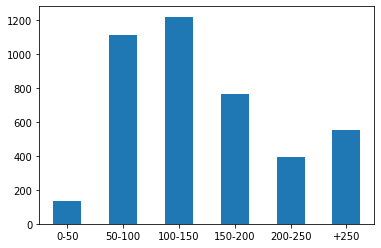

In [285]:
prices = pd.cut(train['price'],
                bins = [0, 50, 100, 150, 200, 250, train["price"].max()],
                labels=["0-50", "50-100", "100-150", "150-200", "200-250", "+250"])
 
prices.value_counts().sort_index().plot(kind="bar", rot = 0)

In [286]:
mayoria = train[train['price']<=250].shape[0]
total = train.shape[0]
mayoria/total #Casi el 87% de los precios estan por debajo de 250€

0.8682505399568035

### LOOKING @ COLUMNS

How does our df's rows look like?
Just like <code>df.head(1)</code>, but nicer ;)

In [287]:
train.sample()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3976,3976,https://www.airbnb.com/rooms/51842355,20211205213126,2021-12-06,Welcome to my city oasis!,Welcome to my beautiful quiet central south si...,NaN,https://a0.muscache.com/pictures/fa9e405c-70ab...,16863369,https://www.airbnb.com/users/show/16863369,Anouk,2014-06-16,"Amsterdam, North Holland, The Netherlands",NaN,NaN,NaN,0%,f,https://a0.muscache.com/im/pictures/user/c92b0...,https://a0.muscache.com/im/pictures/user/c92b0...,NaN,1,1,"['email', 'phone', 'reviews', 'jumio']",t,t,NaN,Zuid,NaN,52.34681,4.8606,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Hair dryer"", ""...",110.0,10,30,10.0,10.0,30.0,30.0,10.0,30.0,NaN,t,0,3,33,123,2021-12-06,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0363 CC5D C979 88CB 65F4,f,1,1,0,0,NaN


In [288]:
#train.iloc[train['id'][0]] 

NaN values

In [289]:
nan_rank = train.isna().sum() #Most to least Nans columns
nan_rank[nan_rank.values > 0].sort_values(ascending=False)

neighbourhood_group_cleansed    4167
calendar_updated                4167
bathrooms                       4167
host_neighbourhood              1786
host_about                      1512
host_response_time              1413
host_response_rate              1413
neighbourhood                   1163
neighborhood_overview           1163
host_acceptance_rate            1092
review_scores_communication      385
review_scores_location           385
review_scores_value              385
review_scores_checkin            385
review_scores_accuracy           385
review_scores_cleanliness        385
first_review                     377
last_review                      377
reviews_per_month                377
review_scores_rating             377
bedrooms                         253
beds                             174
license                           32
host_location                     12
description                        8
bathrooms_text                     8
maximum_nights_avg_ntm             1
m

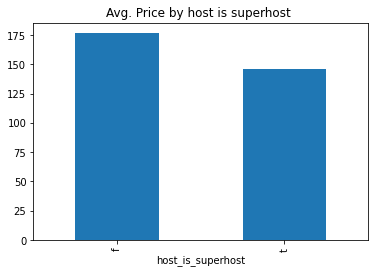

In [290]:
avg_price_superhost = train.groupby('host_is_superhost').mean()["price"]
avg_price_superhost.plot(kind="bar")
plt.title("Avg. Price by host is superhost ")
plt.show()

Al contrario de lo que podríamos esperar, el precio varía en funcion de si el host es Super o No pero
aunque de manera inversa a lo esperable

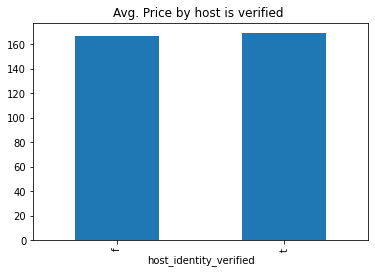

In [291]:
#plt.xticks(rotation=90)

avg_price_host_veri = train.groupby('host_identity_verified').mean()["price"]
avg_price_host_veri.plot(kind="bar")
plt.title("Avg. Price by host is verified ")
plt.show()


### ver como hacer casteo del host acceptance rate porque no me sale ni a palos

In [292]:
#train.host_acceptance_rate.astype(str)
#train.host_acceptance_rate.dtypes

#train.host_acceptance_rate = train.host_acceptance_rate.astype(str)#
#
#acc = pd.cut(train['host_acceptance_rate'],
#                bins = [0, 20, 40, 60, 80, 100],
#                labels=["0-20", "20-40", "40-60", "60-80", "80-100"])
# 
#acc.value_counts().sort_index().plot(kind="bar", rot = 0)

#avg_price_acc = train.groupby('host_acceptance_rate').mean()["price"]
#avg_price_host_veri.plot(kind="bar")
#plt.title("Avg. Price by host is verified ")
#plt.show()

In [293]:
type(train.host_acceptance_rate[0])

str

In [294]:
#CASTEO DEL HOST SINCE-->FUNCION
#train['host_since'] = train['host_since'].astype(str) #FUNCION
#train['host_since'] = pd.to_datetime(train['host_since'], format='%Y-%m-%d')

#Creo columna year_host_since
#train['host_since_year'] = pd.DatetimeIndex(train['host_since']).year
#train['host_since_year'].head()
#train = train.drop('host_since', inplace=True) # OJO QUE ESTO HAY QUE HACERLO DESPUES DE LAS TRANSFORMACIONES
#train.host_since_year.sample
#train['host_since'] = train['host_since'].astype(str)
#train['host_since'].dtypes
#train['host_since'] = pd.to_datetime(train['host_since'], format='%Y%m%d')
#train.host_since.dtype

In [295]:
selection = ['host_is_superhost',
    'host_since']

In [296]:
## host_since --> Me lo puedo cepillar o no??Es un datetime, ver como tranajarlo

## CLUSTERIZANDO LATITUDE Y LONGITUD

### CON HDBSCAN

In [297]:
#0.01 / 6378

### HABLAR CON YONA PARA VER TEMA DE MANTENER LOS GRUPOS CLUSTERIZADOS ANTERIORMENTE:

In [298]:
#latitude y longitud los vamos a clusterizar con DBSCAN: --> METIDO EN UNA FUNCION
#!pip install hdbscan

hdbscan=HDBSCAN(min_cluster_size=3,min_samples=2,cluster_selection_epsilon=0.01,
                allow_single_cluster=False,prediction_data=True,leaf_size=30)
      
#help(hdbscan)
##PARAMS
#algorithm='best', alpha=1.0, approx_min_span_tree=True,
#    gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
#    metric='euclidean', min_cluster_size=5, min_samples=None, p=None

Cuales son la etiquetas de HDBSCAN??

In [299]:
#train.head()

In [300]:
#test=pd.read_csv('data/test.csv.zip') #Cargamos el test para ver como clusteriza los nuevos puntos

In [301]:
#test_points = np.column_stack((test['longitude'],test['latitude']))

In [302]:
#test_labels, strengths = hdbscan.prediction.approximate_predict(clasi, test_points)
#test_labels = clasi.approximate_predict(clasi, test_points)

In [303]:
#help(clasi)

### FUNCION LIMPIEZA:

In [304]:
import funciones as f

In [305]:
train.beds.isna().sum()

174

MIRAR BIEN LO DE CATS / QUE SOLO COGE EL PRIMER
MIRAR TB LO DE LOS AMENITIES QUE ME LOS HE CEPILLADO


In [306]:
#avg_price_host_since = train.groupby('host_since_year').mean()["price"]
#avg_price_host_since.plot(kind="bar")
#plt.title("Avg. Price by host since year")
#plt.show()

# H2O

In [307]:
train_ready = f.clean(train)
train_ready.shape

KeyError: "['calculated_host_listings_count_entire_homes'] not found in axis"

In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=8  # in gigabytes
)

In [ ]:
train_H2o = h2o.H2OFrame(train_ready)

In [ ]:
y = "price" #Target a predecir
splits = train_H2o.split_frame(ratios = [0.8], seed = 42) #Hacemos tts a pelo
train = splits[0]
test = splits[1]

In [ ]:
aml = H2OAutoML(max_models=30, seed=1)
aml.train(y = y, training_frame = train, leaderboard_frame = test)

In [ ]:
lb = aml.leaderboard
lb

In [ ]:
perf = aml.leader.model_performance(test)
perf

In [ ]:
#exm = aml.leader.explain(test)

In [ ]:
PARON

In [ ]:
test = pd.read_csv('data/test.csv.zip')

In [ ]:
f.clean(test)

In [ ]:
testh2o = h2o.H2OFrame(test)

In [ ]:
prediccion_test_completo = aml.leader.predict(testh2o)

In [ ]:
QUIETO

In [ ]:
nombre = 'predicciones4'

In [ ]:
predict = h2o.as_list(prediccion_test_completo)
predict.to_csv(("data/{}.csv".format(nombre)))
sample = pd.read_csv('data/sample.csv')
sample.price = predict.predict  #Cambiamos columna price por la Series de Pandas que tenemos
sample.to_csv('data/modelo4_predict.csv', index = False)

In [ ]:
#Viendo los insgiths de las columnas que me da modelo 4 me puedo cepillar la mitad